In [1]:
# %load sample.py
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
# plt.switch_backend('module://matplotlib_inline.backend_inline')
import matplotlib.ticker as ticker
import numpy as np
from os import system
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

In [2]:
seed = 198964
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
"""========================================================================================
The sample.py includes the following template functions:

1. Encoder, decoder
2. Training function
3. BLEU-4 score function

You have to modify them to complete the lab.
In addition, there are still other functions that you have to 
implement by yourself.

1. Your own dataloader (design in your own way, not necessary Pytorch Dataloader)
2. Output your results (BLEU-4 score, correction words)
3. Plot loss/score
4. Load/save weights
========================================================================================"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#----------Hyper Parameters----------#
embedding_size = 32
hidden_size = 512
#The number of vocabulary
vocab_size = 28
teacher_forcing_ratio = 0.5
LR = 0.05

In [4]:
################################
#Example inputs of compute_bleu
################################
#The target word
reference = 'variable'
#The word generated by your model
output = 'varable'

#compute BLEU-4 score
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

print(compute_bleu(output, reference))

0.5154486831107657


In [5]:
SOS_token = 0
EOS_token = 1
char2index = {"SOS": 0, "EOS": 1}
index2char = {0: "SOS", 1: "EOS"}
a2z = "abcdefghijklmnopqrstuvwxyz"
for index, char in enumerate(a2z, 2):
    char2index[char] = index
    index2char[index] = char

In [6]:
import json
with open("train.json") as f:
    line = json.load(f)

data_list = []
label_list = []
for pair in line:
    label_idx = []
    for character in pair["target"]:
        label_idx.append(char2index[character])
    label_idx.append(char2index["EOS"])
    label_idx = torch.tensor(label_idx)
    for word in pair["input"]:
        word_idx = []
        for character in word:
            word_idx.append(char2index[character])
        word_idx.append(char2index["EOS"])
        word_idx = torch.tensor(word_idx)
        data_list.append(word_idx)
        label_list.append(label_idx)

In [7]:
import json
with open("test.json") as f:
    line = json.load(f)

test_data_list = []
test_label_list = []
for pair in line:
    label_idx = []
    for character in pair["target"]:
        label_idx.append(char2index[character])
    label_idx.append(char2index["EOS"])
    label_idx = torch.tensor(label_idx)
    for word in pair["input"]:
        word_idx = []
        for character in word:
            word_idx.append(char2index[character])
        word_idx.append(char2index["EOS"])
        word_idx = torch.tensor(word_idx)
        test_data_list.append(word_idx)
        test_label_list.append(label_idx)

In [8]:
import json
with open("new_test.json") as f:
    line = json.load(f)

new_test_data_list = []
new_test_label_list = []
for pair in line:
    label_idx = []
    for character in pair["target"]:
        label_idx.append(char2index[character])
    label_idx.append(char2index["EOS"])
    label_idx = torch.tensor(label_idx)
    for word in pair["input"]:
        word_idx = []
        for character in word:
            word_idx.append(char2index[character])
        word_idx.append(char2index["EOS"])
        word_idx = torch.tensor(word_idx)
        new_test_data_list.append(word_idx)
        new_test_label_list.append(label_idx)

In [9]:
# 將input轉成one-hot tensor，為了計算cross-entropy loss(其實也可以不用轉)
def ToOneHot(input_tensor):
    output_tensor = torch.zeros(input_tensor.shape[0], 1, 28)
    for i in range(input_tensor.shape[0]):
        output_tensor[i][0][input_tensor[i]] = 1
    return output_tensor

In [10]:
#Encoder
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size)
        self.rnn = nn.RNN(embedding_size, hidden_size)
#         self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(-1, 1, self.embedding_size)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
#Decoder
class DecoderRNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.teacher_forcing_ratio = 0.5

        self.embedding = nn.Embedding(output_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size)
        self.rnn = nn.RNN(embedding_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden):
        output = self.embedding(input).view(-1, 1, self.embedding_size)
        output, hidden = self.gru(output, hidden)
        output = self.log_softmax(self.out(output))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
# train 一個單字
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn):
    encoder.train()
    decoder.train()
    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    target_length = len(target_tensor)
    target_1hot = ToOneHot(target_tensor).to(device)
    loss = 0

    #----------sequence to sequence part for encoder----------#
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    
    decoder_input = torch.tensor([SOS_token], device=device)
    decoder_hidden = encoder_hidden
    decoder_outputs = torch.zeros(target_length, 1, 28).to(device)
    EOS = torch.tensor([EOS_token], device=device)
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
	

    #----------sequence to sequence part for decoder----------#
    for di in range(target_length):
        if decoder_input == EOS:
            break
        else:
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoder_outputs[di][0] = decoder_output
            loss += loss_fn(decoder_output.view(1, -1), target_1hot[di])

            if use_teacher_forcing: # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[di].view(1,).to(device)  # Teacher forcing
            else:
                decoder_input = decoder_output.argmax()

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [13]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [14]:
# train 整個dataset
def trainIters(data_list, label_list, encoder, decoder, n_iters,
               print_every=1000, plot_every=100, learning_rate=0.0001, plot_history=[]):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    loss_fn = nn.CrossEntropyLoss()

    for i in range(n_iters):
        input_tensor = data_list[i]
        target_tensor = label_list[i]
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, loss_fn)
        print_loss_total += loss
        plot_loss_total += loss

        if (i+1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, i / (n_iters+1)),
                                         i, i / (n_iters+1) * 100, print_loss_avg), end="\r")
    plot_history.append(plot_loss_total / len(data_list))
    print("\nLoss:", plot_loss_total / len(data_list))

In [15]:
# 計算bleu score
def Evaluate_bleu(test_data, test_label, encoder, decoder):
    with torch.no_grad():
        total_bleu = 0.
        for i in range(len(test_data)):
            init_hid = encoder.initHidden()
            out, hid = encoder(test_data[i].to(device), init_hid)
            dec_hid = hid
            dec_in = torch.tensor([SOS_token], device=device)
            generated_word = []
            while True: # 直到遇到EOS才停止output
                dec_out, dec_hid = decoder(dec_in, dec_hid)
                generated_word.append(index2char[dec_out.argmax(dim=2).item()])
                dec_in = dec_out.argmax(dim=2).view(1,)
                if dec_in.item() == EOS_token:
                    break

            target_word = []
            for j in range(len(test_label[i])):
                target_word.append(index2char[test_label[i][j].item()])
                
            total_bleu += compute_bleu(generated_word, target_word)
        return total_bleu / len(test_data)

In [16]:
encoder1 = EncoderRNN(vocab_size, embedding_size, hidden_size).to(device)
decoder1 = DecoderRNN(embedding_size, hidden_size, vocab_size).to(device)

In [17]:
encoder2 = EncoderRNN(vocab_size, embedding_size, hidden_size).to(device)
encoder2.load_state_dict(torch.load('ENCODER.pt'))
decoder2 = DecoderRNN(embedding_size, hidden_size, vocab_size).to(device)
decoder2.load_state_dict(torch.load('DECODER.pt'))

<All keys matched successfully>

In [18]:
plot_history = []
bleu_history = []

In [48]:
# train n 個 epochs
for i in range(10):
    print(f"Epochs: {i}")
    trainIters(data_list, label_list, encoder1, decoder1, len(data_list), plot_history=plot_history)
    bleu_score = Evaluate_bleu(test_data_list, test_label_list, encoder1, decoder1)
    print(f"Bleu score: {bleu_score}")
    bleu_history.append(bleu_score)

Epochs: 0
1m 24s (- 0m 6s) (11999 92%) 0.17589
Loss: 0.12336933551142529
Bleu score: 0.8770704954018517
Epochs: 1
1m 24s (- 0m 6s) (11999 92%) 0.15810
Loss: 0.120195486404005
Bleu score: 0.9006037215942103
Epochs: 2
1m 25s (- 0m 6s) (11999 92%) 0.17934
Loss: 0.11890434707906214
Bleu score: 0.8919344951349902
Epochs: 3
1m 23s (- 0m 6s) (11999 92%) 0.18187
Loss: 0.11959099282184883
Bleu score: 0.8730594113817522
Epochs: 4
1m 26s (- 0m 6s) (11999 92%) 0.15717
Loss: 0.11703782139363664
Bleu score: 0.8693096387096366
Epochs: 5
1m 22s (- 0m 6s) (11999 92%) 0.15877
Loss: 0.11858793360134157
Bleu score: 0.8584508680375244
Epochs: 6
1m 22s (- 0m 6s) (11999 92%) 0.16951
Loss: 0.11964487737871377
Bleu score: 0.9028347527010527
Epochs: 7
1m 22s (- 0m 6s) (11999 92%) 0.15918
Loss: 0.11447989453306068
Bleu score: 0.8508394932592911
Epochs: 8
1m 22s (- 0m 6s) (11999 92%) 0.15391
Loss: 0.11452729004680122
Bleu score: 0.8859605680175617
Epochs: 9
1m 23s (- 0m 6s) (11999 92%) 0.14959
Loss: 0.11656042567

In [93]:
# 印出encoder, decoder產生的單字
using_data = new_test_data_list
using_label = new_test_label_list
word_idx = 36 # dataset的第i筆資料
with torch.no_grad():
    init_hid = encoder1.initHidden()
    out, hid = encoder1(using_data[word_idx].to(device), init_hid)
    dec_hid = hid
    dec_in = torch.tensor([SOS_token], device=device)
    generated_word = []
#     for i in range(len(using_label[word_idx])):
    while True:
        dec_out, dec_hid = decoder1(dec_in, dec_hid)
        generated_word.append(index2char[dec_out.argmax(dim=2).item()])
        dec_in = dec_out.argmax(dim=2).view(1,)
        if dec_in.item() == EOS_token:
            break
    print(generated_word)

['f', 'e', 'a', 't', 'u', 'r', 'e', 'EOS']


In [94]:
# 印出正確答案
target_word = []
for i in range(len(using_label[word_idx])):
    target_word.append(index2char[using_label[word_idx][i].item()])
print(target_word)

['f', 'e', 'a', 't', 'u', 'r', 'e', 'EOS']


In [45]:
# 印出產生的單字與正確答案的bleu score
compute_bleu(generated_word, target_word)

1.0

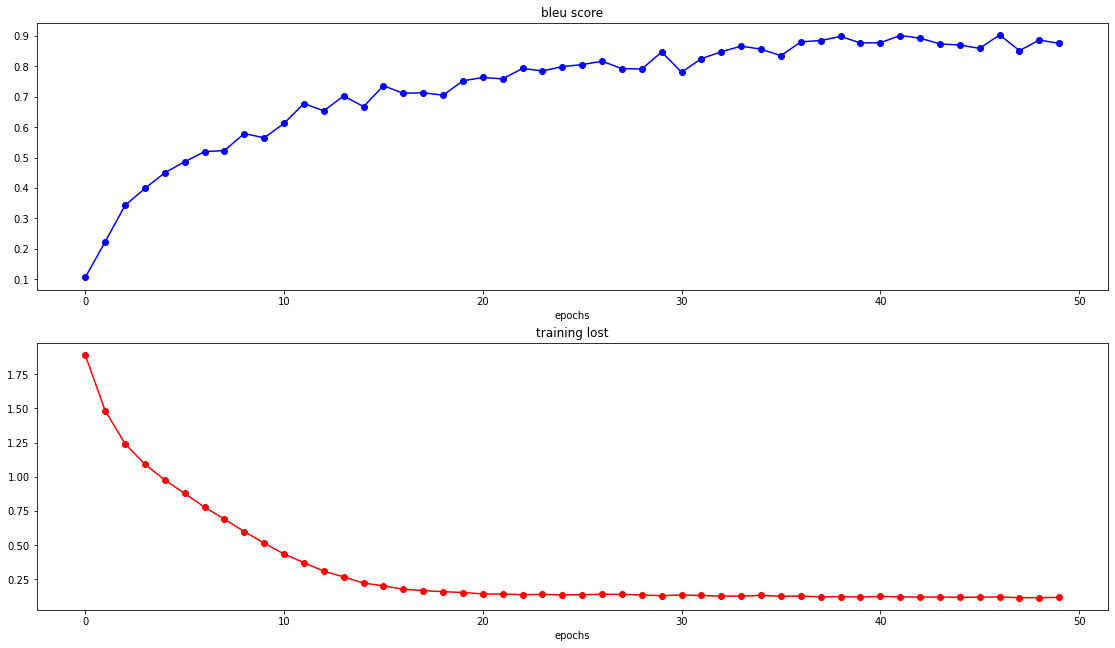

In [75]:
x = np.arange(len(plot_history))
fig = plt.figure(figsize=(19.2, 10.8))
ax1 = plt.subplot(211, title="bleu score", xlabel="epochs")
ax2 = plt.subplot(212, title="training lost", xlabel="epochs")
ax1.plot(x, bleu_history, 'bo')
ax1.plot(x, bleu_history, 'b')
ax2.plot(x, plot_history, 'ro')
ax2.plot(x, plot_history, 'r')

In [55]:
# 計算new test的bleu score
Evaluate_bleu(new_test_data_list, new_test_label_list, encoder1, decoder1)

0.630149680129464

In [54]:
# 儲存model參數
torch.save(encoder1.state_dict(), 'ENCODER_epochs_50.pt')
torch.save(decoder1.state_dict(), 'DECODER_epochs_50.pt')

---

# Report
我發現在train RNN 的model時，learning rate不可以調太大，因為無論是encoder還是decoder，
中間RNN layer的weight會重複乘上n次(n相當於單字的length)，<br>所以些微的weight更動會影響很大。
Train 50 個epochs後我發現雖然test表現好很多，不過new test因為單字錯誤的比較離譜，而這個
model不太有遇到離譜錯誤<br>的修正能力，可能使用dropout隨機把喂進decoder的input換成隨機的字母或
無意義的符號會有幫助，或使用看看雙向的RNN，因為雙向可以看前後文的關係，不<br>過參數也會變成兩倍，
train的時間會拖更久。另外也可以試著把RNN多增加幾層，不過超參數可能要調整一下。